In [10]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import sklearn.neighbors as NN
from scipy.sparse.linalg import cg

In [11]:
def weight_array_calc(dim, positions, kh, NN_idx):
    weight_array = np.zeros((len(positions), len(NN_idx)))
    for i in range(len(positions)):
        for j in NN_idx[i]:
            r_ij = positions[i] - positions[j]
            distance = np.linalg.norm(r_ij)
            if distance < kh and distance > 0.0:
                weight_array[i][j] = ker(kh, dim, distance)
    return weight_array

In [12]:
def weight_array_calc_complete(dim, positions, kh, NN_idx):
    weight_array = np.zeros((len(positions), len(positions)))
    for i in range(len(positions)):
        for j in NN_idx[i]:
            r_ij = positions[i] - positions[j]
            distance = np.linalg.norm(r_ij)
            if distance < kh and distance > 0.0:
                weight_array[i][j] = ker(kh, dim, distance)
    return weight_array

In [13]:
def update_pressure_complete(args):
    dim, i, positions, velocities, density, pressure, mass, dt, kh, NN_idx, div = args
    h = kh/2
    h1 = 1/h
    n = len(positions)
    A = np.zeros((n,n))
    b = np.zeros(n)
    weight_array = weight_array_calc(dim, positions, kh, NN_idx)
    for i in range(n):
        for j in NN_idx[i]:
            r_ij = positions[i] - positions[j]
            distance = np.linalg.norm(r_ij)
        
            if distance < kh and distance > 0.0:
                A[i][j] = mass / density[i] * weight_array[i][j]
                A[i][i] = sum(mass / density[j] * weight_array[i][j] for j in NN_idx[i] if i !=j)  # diagonal term
                b[i] = dt * div[i] / density[i]
                # pressure_gradient += weight * (pressure[i] - pressure[j]) * r_ij / (distance + 1e-6)
                # divergence += np.dot(velocities[i] - velocities[j], r_ij) / (distance + 1e-6)
    new_pressure, info = cg(A, b)
    print(new_pressure)
    return i, new_pressure

In [14]:
def update_pressure_single(args):
    dim, i, positions, velocities, density, pressure, mass, dt, kh, NN_idx, div = args
    h = kh/2
    h1 = 1/h
    n = len(positions)
    A = np.zeros((n,n))
    b = np.zeros(n)
    weight_array = weight_array_calc_complete(dim, positions, kh, NN_idx)
    for j in NN_idx[i]:
        r_ij = positions[i] - positions[j]
        distance = np.linalg.norm(r_ij)
        
        if distance < kh and distance > 0.0:
            A[i][j] = mass / density[i] * weight_array[i][j]
            A[i][i] = sum(mass / density[j] * weight_array[i][j] for j in NN_idx[i] if i !=j)  # diagonal term
            b[i] = dt * div[i] / density[i]
            # pressure_gradient += weight * (pressure[i] - pressure[j]) * r_ij / (distance + 1e-6)
            # divergence += np.dot(velocities[i] - velocities[j], r_ij) / (distance + 1e-6)
    new_pressure, info = cg(A, b)
    
    return i, new_pressure
def update_pressure(args):
    dim, i, positions, velocities, density, pressure, mass, dt, kh, NN_idx, div = args
    h = kh/2
    h1 = 1/h
    n = len(positions)
    A = np.zeros((n,n))
    b = np.zeros(n)
    weight_array = weight_array_calc(dim, positions, kh, NN_idx)
    for j in NN_idx[i]:
        r_ij = positions[i] - positions[j]
        distance = np.linalg.norm(r_ij)
        
        if distance < kh and distance > 0.0:
            A[i][j] = mass / density[i] * weight_array[i][j]
            A[i][i] = sum(mass / density[j] * weight_array[i][j] for j in NN_idx[i] if i !=j)  # diagonal term
            b[i] = dt * div[i] / density[i]
            # pressure_gradient += weight * (pressure[i] - pressure[j]) * r_ij / (distance + 1e-6)
            # divergence += np.dot(velocities[i] - velocities[j], r_ij) / (distance + 1e-6)
    new_pressure, info = cg(A, b)
    
    return i, new_pressure

In [15]:
def update_velocity(args):
    dim, i, positions, velocities, density, density_sqr, pressure, dt, kh, NN_idx = args
    pressure_gradient = np.zeros(3)
    h = kh/2
    h1 = 1/h
    for j in NN_idx[i]:
        r_ij = positions[i] - positions[j]
        distance = np.linalg.norm(r_ij)
        
        temp = 0
        if distance < kh and distance > 0.0:
            # xij = positions[j] - positions[i]
            gradient_ = gradient(dim, r_ij, distance, kh)
            # weight = gradient(dim, r_ij, distance, kh)
            temp = mass*((pressure[i]/density_sqr[i]) - (pressure[j]/density_sqr[j])) 
            pressure_gradient += temp * gradient_
    new_velocity = velocities[i] - dt * pressure_gradient / density[i]
    return i, new_velocity

In [16]:
def solve_pressure_poisson(dim, positions, velocities, density, density_sqr, pressure, mass, dt, h, NN_idx, divergence, tolerance=1e-6, max_iterations=1000):
    """
    Solves the Pressure Poisson Equation to enforce a divergence-free velocity field.
    
    Parameters:
    - positions: array of particle positions (N x 3)
    - velocities: array of particle velocities (N x 3)
    - density: array of particle densities (N)
    - pressure: array of particle pressures (N)
    - mass: mass of each particle (scalar)
    - dt: time step
    - h: smoothing length
    - NN_idx: list of nearest neighbors for each particle
    - tolerance: convergence tolerance for the iterative solver
    - max_iterations: maximum number of iterations for the solver
    
    Returns:
    - Updated pressures and velocities
    """
    num_particles = len(positions)
    
    pool = mp.Pool(mp.cpu_count())
    max_iteration = np.zeros(num_particles)
    div =np.zeros(num_particles)
    
    # Iteratively solve the Pressure Poisson Equation
    for iteration in range(max_iterations):

        # Calculate the velocity divergence to check again
        # Prepare arguments for each particle
        pressure_args = [(dim, i, positions, velocities, density, pressure, mass, dt, h, NN_idx, div) for i in range(num_particles)]
        print("pressure args")
        
        # Compute pressure in parallel
        # pressure_results = pool.map(update_pressure, pressure_args)
        args = [dim, 0, positions, velocities, density, pressure, mass, dt, h, NN_idx, div]
        pressure_results_complete = update_pressure_complete(args)
        # pressure_results_complete = update_pressure_complete(dim, 0, positions, velocities, density, pressure, mass, dt, h, NN_idx, div)
        print("pressure results")
        _,pressure = pressure_results_complete
        
        # Collect the results
        # for i, new_pressure in pressure_results:
        #     pressure[i] = new_pressure

        # Prepare arguments for each particle
        velocity_args = [(dim, i, positions, velocities, density, density_sqr, pressure, dt, h, NN_idx) for i in range(num_particles)]
    
        # Update velocities in parallel
        velocity_results = pool.map(update_velocity, velocity_args)
    
        # Collect the results
        for i, new_velocity in velocity_results:
            velocities[i] = new_velocity
        div = calculate_velocity_divergence(dim, positions, velocities, density, mass, h, NN_idx)
        print("divergence calculation")
        is_non_divergent, max_divergence_pre = check_non_divergent(div)
        print(f"Is the flow non-divergent? {is_non_divergent}")
        print(f"Maximum divergence: {max_divergence_pre}")
        # Check for reduction in velocity divergence
        max_error = np.max(np.abs(div))
        if max_error < tolerance:
            break
        if iteration == max_iterations - 1:
            max_iteration[i] = 1
    pool.close()
    pool.join()
    print(f"Max iterations reached for {np.sum(max_iteration)} particles")
    return pressure, velocities
def get_fac(h1, dim):
    # get the kernel normalizing factor
    if dim == 1:
        fac = 2/3
        fac = fac * h1
        return fac
    elif dim == 2:
        fac = 10/(7 * np.pi)
        fac = fac * h1 * h1
        return fac
    elif dim == 3:
        fac = 1/(np.pi)
        fac = fac * h1 * h1 * h1
        return fac

Cubic spline kernel

In [17]:
def ker(kh, dim, rij):
    h = kh/2
    h1 = 1/h
    q = rij * h1
    fac = get_fac(h1, dim)
    tmp2 = 2. - q
    if (q > 2.0):
        val = 0.0
    elif (q > 1.0):
        val = 0.25 * tmp2 * tmp2 * tmp2
    else:
        val = 1 - 1.5 * q * q * (1 - 0.5 * q)
    return val * fac

In [18]:
def dwdq(kh, dim, rij=1.0):
        """Gradient of a kernel is given by
        .. math::
            \nabla W = normalization  \frac{dW}{dq} \frac{dq}{dx}
            \nabla W = w_dash  \frac{dq}{dx}
        Here we get `w_dash` by using `dwdq` method
        """
        h = kh / 2
        h1 = 1. / h
        q = rij * h1
        fac = get_fac(h1, dim)
        # compute sigma * dw_dq
        tmp2 = 2. - q
        if (rij > 1e-12):
            if (q > 2.0):
                val = 0.0
            elif (q > 1.0):
                val = -0.75 * tmp2 * tmp2 
            else:
                val = -3.0 * q * (1 - 0.75 * q) 
        else:
            val = 0.0
        return val * fac
    
def gradient(dim, xij=[0., 0, 0], rij=1.0, kh=1.0, grad=[0, 0, 0]):
    h = kh / 2
    h1 = 1. / h
    # compute the gradient.
    if (rij > 1e-12):
        wdash = dwdq(rij, dim,  h)
        tmp = wdash * h1 / rij
    else:
        tmp = 0.0
    grad[0] = tmp * xij[0]
    grad[1] = tmp * xij[1]
    grad[2] = tmp * xij[2]
    return (grad)

In [19]:
def gradient_h(dim, xij=[0., 0, 0], rij=1.0, kh=1.0):
    h = kh / 2
    h1 = 1. / h
    q = rij * h1
    fac = get_fac(h1, dim)

    # kernel and gradient evaluated at q
    tmp2 = 2. - q
    if (q > 2.0):
        w = 0.0
        dw = 0.0
    elif (q > 1.0):
        w = 0.25 * tmp2 * tmp2 * tmp2
        dw = -0.75 * tmp2 * tmp2
    else:
        w = 1 - 1.5 * q * q * (1 - 0.5 * q)
        dw = -3.0 * q * (1 - 0.75 * q)
    return -fac * h1 * (dw * q + w * dim)

In [20]:
def ker_lap(kh, dim, rij):
    h = kh/2
    h1 = 1/h
    q = rij * h1
    fac = get_fac(h1, dim)
    tmp2 = 2. - q
    if (q > 2.0):
        val = 0.0
    elif (q > 1.0):
        val = -3 * tmp2 *h1 / 2
    else:
        val = -3 * (1 - 1.5 * q * q) * h1
    return val * fac

In [21]:
def calculate_divergence_for_particle(args):
    dim, i, positions, velocities, density, mass, kh, NN_idx = args
    div = 0.0
    
    for j in NN_idx[i]:
        r_ij = positions[i] - positions[j]
        distance = np.linalg.norm(r_ij)
        
        if distance < kh and distance > 0.0:
            xij = positions[j] - positions[i]
            weight = gradient(dim, xij, distance, kh)
            temp = np.dot(velocities[j] - velocities[i], weight)
            temp = temp * mass* distance/ (distance + 1e-6)
            div +=  temp
        div = div / density[i]
    
    return i, div

In [22]:
def calculate_velocity_divergence(dim, positions, velocities, density, mass, h, NN_idx):
    """
    Calculate the velocity divergence for each particle in parallel.
    
    Parameters:
    - positions: array of particle positions (N x 3)
    - velocities: array of particle velocities (N x 3)
    - density: array of particle densities (N)
    - mass: mass of each particle (scalar)
    - h: smoothing length
    - NN_idx: list of nearest neighbors for each particle
    
    Returns:
    - divergence: array of velocity divergences for each particle (N)
    """
    num_particles = len(positions)
    divergence = np.zeros(num_particles)
    results = np.zeros(num_particles)
    
    # Create a pool of worker processes
    pool = mp.Pool(mp.cpu_count())
    
    # Prepare arguments for each particle
    args = [(dim, i, positions, velocities, density, mass, h, NN_idx) for i in range(num_particles)]
    
    # Compute divergence in parallel
    results = pool.map(calculate_divergence_for_particle, args)
    # for arg in args:
    #     i, div = calculate_divergence_for_particle(arg)
    #     results[i] = div
    
    # Close the pool and wait for all processes to finish
    pool.close()
    pool.join()
    
    # Collect the results
    for i, div in results:
        divergence[i] = div
    
    return divergence

In [23]:
def check_non_divergent(divergence, tolerance=1e-6):
    max_divergence = np.max(np.abs(divergence))
    is_non_divergent = max_divergence < tolerance
    return is_non_divergent, max_divergence

In [24]:
def plot_comp(positions, data, time):
    import matplotlib.pyplot as plt
    plt.clf()
    plt.scatter(positions[:, 0], positions[:, 2], c=data)
    plt.colorbar()
    plt.savefig(f"output_{time}.png")
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c=data)
    # plt.show()
    # plt.savefig("output.png")

In [25]:
def save_comp(positions, data, file):
    np.savetxt(file, np.column_stack((positions, data)), delimiter=";", header="x;y;z;data")

In [26]:
def boxplot_div(div_pre, div_post):
    plt.clf()
    plt.boxplot([div_pre, div_post], labels=["Pre", "Post"])
    plt.savefig("boxplot.png")

In [27]:
def histogram_div(div_pre, div_post):
    plt.clf()
    plt.hist(div_pre, bins=50, histtype='step', label='Pre')
    plt.hist(div_post, bins=50, histtype='step', label='Post')
    plt.xscale('log')
    plt.legend(loc='upper right')
    plt.savefig("histogram_post.png")

Example usage<br>
2d<br>
==============

In [28]:
dim = 2
Kernel = 0.02
kh = Kernel *2
dp = 0.008
mass = 0.064
file = "./data_2d/out_0099.csv"
#===============
# 3D
#===============
# dim = 3
# Kernel = 0.008660
# kh = Kernel *2
# dp = 0.005
# mass = 0.000125
# file = "./data_3d/Out_0149.csv"
#===============
data = np.loadtxt(file, delimiter=";", skiprows=4, usecols=(0,1,2,3,4,5,6,7,8,9))
pos_x = data[:, 0]
pos_y = data[:, 1]
pos_z = data[:, 2]
idp = data[:, 4]
positions = np.column_stack((pos_x, pos_y, pos_z))
vel_x = data[:, 4]
vel_y = data[:, 5]
vel_z = data[:, 6]
velocities = np.column_stack((vel_x, vel_y, vel_z))
density = data[:,7]
pressure = data[:,8]
print("the position of first 5 particles are: ", positions[:5])

the position of first 5 particles are:  [[-0.016  0.     0.008]
 [-0.016  0.     0.016]
 [-0.008  0.     0.008]
 [-0.008  0.     0.016]
 [ 0.     0.     0.008]]


In [29]:
nbrs = NN.NearestNeighbors(radius=kh, algorithm='kd_tree').fit(positions)
NN_idx = nbrs.radius_neighbors(positions)[1]
print(np.shape(positions))
print(f"shape of NN_idx: {type(NN_idx)}")
print(f"Average number of neighbors: {np.mean([len(idx) for idx in NN_idx])}")

(17161, 3)
shape of NN_idx: <class 'numpy.ndarray'>
Average number of neighbors: 75.75916321892663


Is the flow non-divergent? False
Maximum divergence: 2.848690867497805


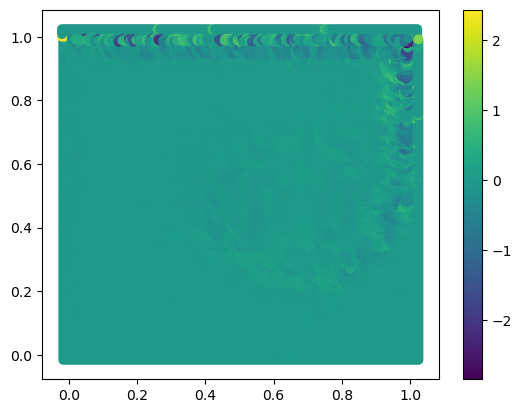

In [30]:
divergence_pre = calculate_velocity_divergence(dim, positions, velocities, density, mass, kh, NN_idx)
is_non_divergent, max_divergence_pre = check_non_divergent(divergence_pre)
print(f"Is the flow non-divergent? {is_non_divergent}")
print(f"Maximum divergence: {max_divergence_pre}")
plot_comp(positions, divergence_pre,"pre")
save_comp(positions, divergence_pre, "output_pre.csv")

In [31]:
dt = 0.01  # Time step

In [ ]:
density_sqr = density ** 2
pressure, velocities = solve_pressure_poisson(dim, positions, velocities, density, density_sqr, pressure, mass, dt, kh, NN_idx, divergence_pre)

In [ ]:
divergence_post = calculate_velocity_divergence(dim, positions, velocities, density, mass, kh, NN_idx)
is_non_divergent, max_divergence_post = check_non_divergent(divergence_post)

In [ ]:
print(f"Is the flow non-divergent? {is_non_divergent}")
print(f"Maximum divergence: {max_divergence_post}")
save_comp(positions, divergence_post, "output_post.csv")

In [ ]:
plot_comp(positions, divergence_post, "post")

In [ ]:
boxplot_div(divergence_pre, divergence_post)
histogram_div(divergence_pre, divergence_post)